In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

%matplotlib inline

# Plane fit

Se pretende determinar los parametros $A,B$ y $C$ de la función $f(x,y)=Ax+By+C$ que representa un plano dado un  conjunto de puntos $\{[x_{1},y_{1},z_{1}]...[x_{n},y_{n},z_{n}]\}$ con el método de mínimos cuadrados. la función a minimizar será la distancia al cuadrado de un punto con el plano.

In [2]:
def plot_plane(A,B,C,figure,R):
    # Plane: z = Ax+By+C
    # create x,y
    xx, yy = np.meshgrid(range(-R,R), range(-R,R))
    z = A*xx + B*yy + C
    figure.plot_surface(xx, yy, z,alpha=0.1)
    
def dist_point_plane(a,b,c,d,point):
    x,y,z = point[:,0],point[:,1],point[:,2]
    dist = np.abs(a*x+b*y+c*z+d)/np.linalg.norm([a,b,c])
    return dist
    
def sigma(A,B,C,D,set_points):# Calcula la mediana y promedio de las distancias de los puntos al plano ajustado 
    all_dist = dist_point_plane(A,B,C,D,set_points)
    return np.median(all_dist), np.mean(all_dist)

def plane(x, y, params):
    A = params[0]
    B = params[1]
    C = params[2]
    D = params[3]
    z = -(A*x + B*y + D)/C
    return z

def error(params, points): #funcion a minimizar
    A,B,C,D = params
    diff = dist_point_plane(A,B,C,D,points)
    return diff # se calcula la diferencia entre el punto z (dato) y el punto z del plano calculado

## Test

El plano: Ax+By+Cz+D=0 tiene como parametros

A = 3.170  B = 3.162  C = 3.158  D = 3.136
El sigma es de: 0.0161871925317 determinado por la mediana
El sigma es de: 0.0194643578742 determinado por el promedio


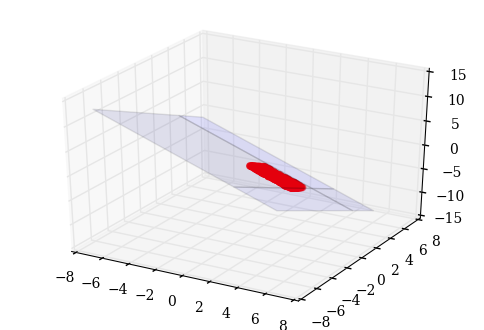

In [3]:
figure = plt.figure().gca(projection='3d')

#Se genera un set de datos x,y de forma aleatoria
x_value = 3*np.random.random_sample(500)
y_value = 2*np.random.random_sample(500)

#                   IMPORTANTE
#Se asume que cada punto pertenece a un plano diferente
#Pero siguen una distribucion normal en los parametros
#Por lo que el resultado deberia parecerce a la media de los parametros (o ser un multiplo escalar)
#loc es la media y scale el sigma de la gausseana, se puede jugar con estos parametros
#A scale muy alto se pierde simetría del problema y en ese caso habría que pesar los datos
#Si en la simulacion es un disco bien definido no deberia haber mayores problemas
Arand = np.random.normal(loc=1,scale=0.01,size=500)
Brand = np.random.normal(loc=1,scale=0.01,size=500)
Crand = np.random.normal(loc=1,scale=0.01,size=500)
Drand = np.random.normal(loc=1,scale=0.01,size=500)


z_value = plane(x_value,y_value,[Arand,Brand,Crand,Drand])

points = np.stack([x_value,y_value,z_value],axis=1)

#Realiza minimos cuadrados a la funcion error con argumentos los puntos
x0 = [1,1,1,1]
result = least_squares(error, x0, args=(points,)) 

A,B,C,D = result.x[0],result.x[1],result.x[2],result.x[3]

print 'El plano: Ax+By+Cz+D=0 tiene como parametros\n'
print 'A =','%.3f'%A,' B =','%.3f'%B,' C =','%.3f'%C,' D =','%.3f'%D
print 'El sigma es de:',sigma(A,B,C,D,points)[0],'determinado por la mediana'
print 'El sigma es de:',sigma(A,B,C,D,points)[1],'determinado por el promedio'


plot_plane(-A/C,-B/C,-D/C,figure,7)
figure.scatter(points[:,0],points[:,1],points[:,2],color='red',linewidths=1)

plt.show()

## Fichero de prueba

In [4]:
pfile=np.loadtxt('/home/pedro/Pedro_PUC/Rutina_Python/xyzprimary.dat')
pfile =np.array(pfile)

#Se genera un set de datos x,y de forma aleatoria
x_value = pfile[:,0]
y_value = pfile[:,1]
z_value = pfile[:,2]

points = np.stack([x_value,y_value,z_value],axis=1)

#Realiza minimos cuadrados a la funcion error con argumentos los puntos
x0 = [1,1,1,1]
result = least_squares(error, x0, args=(points,)) 

A,B,C,D = result.x[0],result.x[1],result.x[2],result.x[3]

print 'El plano: Ax+By+Cz+D=0 tiene como parametros\n'
print 'A =','%.3f'%A,' B =','%.3f'%B,' C =','%.3f'%C,' D =','%.3f'%D
print 'El sigma es de:',sigma(A,B,C,D,points)[0],'determinado por la mediana'
print 'El sigma es de:',sigma(A,B,C,D,points)[1],'determinado por el promedio'
print 'El costo es de:',result.cost

El plano: Ax+By+Cz+D=0 tiene como parametros

A = 48.631  B = -3.192  C = 2.350  D = 3.025
El sigma es de: 0.460434606867 determinado por la mediana
El sigma es de: 0.613628541554 determinado por el promedio
El costo es de: 8148.75644163


## Visualización del ajuste

Lo que se hace a continuación tiene por objetivo rotar los puntos y por consiguiente el plano para que quede paralelo a uno de los planos que hacen los ejes cartesianos y así obtener un mejor plot del ajuste.

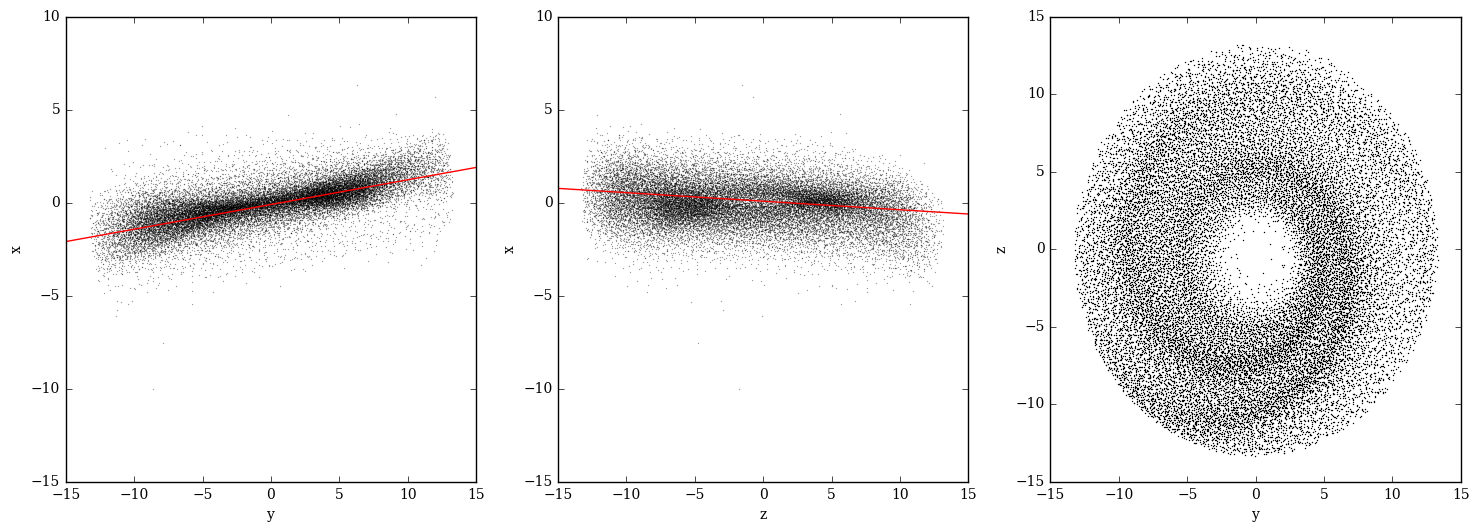

In [5]:
norm_vec = np.array([A,B,C])

theta0 = np.arccos(1./np.linalg.norm(norm_vec)) + 3*np.pi/2
phi0 = np.arccos(A/np.linalg.norm([A,B])) 

# Matriz de rotacion en torno al eje z
rot_z = np.matrix([[np.cos(phi0),-np.sin(phi0),0],[np.sin(phi0),np.cos(phi0),0],[0,0,1]])
# Matriz de rotacion en torno al eje x
rot_x = np.matrix([[1,0,0],[0,np.cos(theta0),-np.sin(theta0)],[0,np.sin(theta0),np.cos(theta0)]])
# Matriz de la rotacion completa
rot_total = (rot_z*rot_x)

rot_points = (points*rot_total).A

x0 = [1,1,1,1]
Rotresult = least_squares(error, x0, args=(rot_points,)) 

rotA,rotB,rotC,rotD = Rotresult.x[0],Rotresult.x[1],Rotresult.x[2],Rotresult.x[3]

aux = np.linspace(-15,15,100)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
ax[0].plot(rot_points[:,1],rot_points[:,0],'k.',ms=1,alpha=0.3)
ax[0].plot(aux,-(rotB*aux+rotC+rotD)/rotA,'-r')
ax[0].set(xlabel='y', ylabel='x')

ax[1].plot(rot_points[:,2],rot_points[:,0],'k.',ms=1,alpha=0.3)
ax[1].plot(aux,-(rotB+rotC*aux+rotD)/rotA,'-r')
ax[1].set(xlabel='z', ylabel='x')

ax[2].plot(rot_points[:,1],rot_points[:,2],'k.',ms=1)
ax[2].set(xlabel='y', ylabel='z')


En rojo se ve el plano de canto, como se visualiza el ajuste no es muy exacto en las partes interiores, para ello se pretende eliminar los puntos que superen cierto umbral en la distancia al plano.

A continuacion se realiza el mismo procedimiento para el disco circumbinario.

In [6]:
pfile=np.loadtxt('/home/pedro/Pedro_PUC/Rutina_Python/xyzcircumbinary.dat')
pfile =np.array(pfile)

#Se genera un set de datos x,y de forma aleatoria
x_value = pfile[:,0]
y_value = pfile[:,1]
z_value = pfile[:,2]

points = np.stack([x_value,y_value,z_value],axis=1)

#Realiza minimos cuadrados a la funcion error con argumentos los puntos
x0 = [1,1,1,1]
result = least_squares(error, x0, args=(points,)) 

A,B,C,D = result.x[0],result.x[1],result.x[2],result.x[3]

print 'El plano: Ax+By+Cz+D=0 tiene como parametros\n'
print 'A =','%.3f'%A,' B =','%.3f'%B,' C =','%.3f'%C,' D =','%.3f'%D
print 'El sigma es de:',sigma(A,B,C,D,points)[0],'determinado por la mediana'
print 'El sigma es de:',sigma(A,B,C,D,points)[1],'determinado por el promedio'
print 'El costo es de:',result.cost

El plano: Ax+By+Cz+D=0 tiene como parametros

A = 11.285  B = -0.439  C = 4.036  D = -0.316
El sigma es de: 9.76927652644 determinado por la mediana
El sigma es de: 15.1083505555 determinado por el promedio
El costo es de: 252435265.487


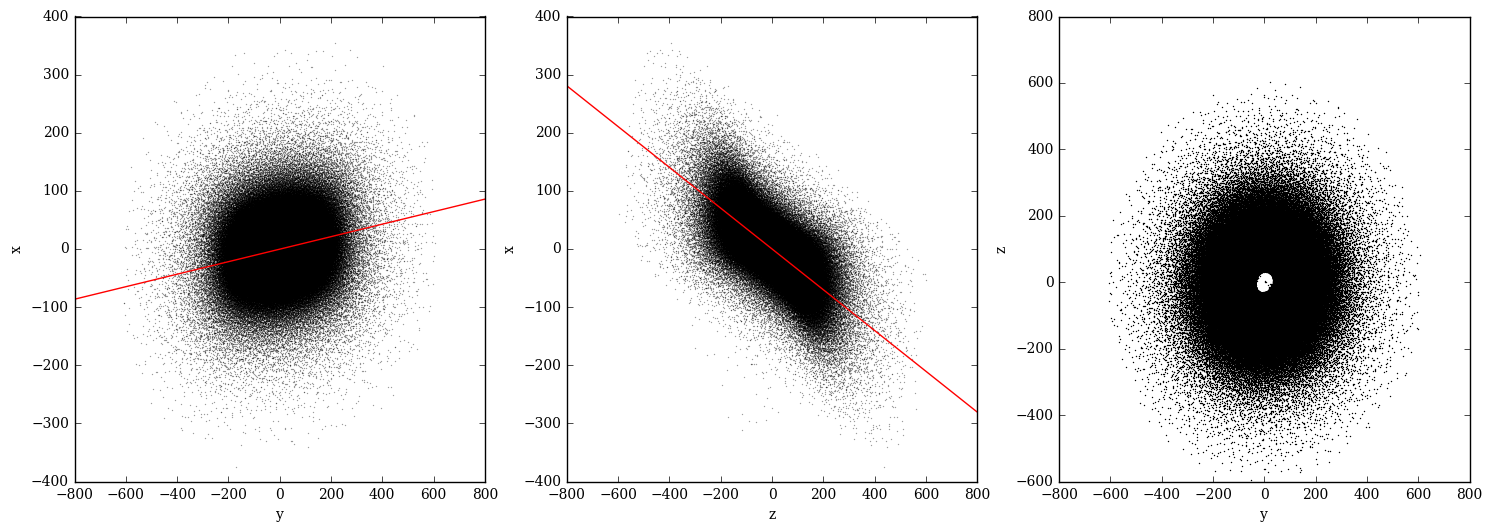

In [7]:
norm_vec = np.array([A,B,C])

theta0 = np.arccos(1./np.linalg.norm(norm_vec)) + 3*np.pi/2
phi0 = np.arccos(A/np.linalg.norm([A,B])) 

rot_z = np.matrix([[np.cos(phi0),-np.sin(phi0),0],[np.sin(phi0),np.cos(phi0),0],[0,0,1]])
rot_x = np.matrix([[1,0,0],[0,np.cos(theta0),-np.sin(theta0)],[0,np.sin(theta0),np.cos(theta0)]])
rot_total = (rot_z*rot_x)

rot_points = (points*rot_total).A

x0 = [1,1,1,1]
Rotresult = least_squares(error, x0, args=(rot_points,)) 

rotA,rotB,rotC,rotD = Rotresult.x[0],Rotresult.x[1],Rotresult.x[2],Rotresult.x[3]

aux = np.linspace(-800,800,100)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
ax[0].plot(rot_points[:,1],rot_points[:,0],'k.',ms=1,alpha=0.3)
ax[0].plot(aux,-(rotB*aux+rotC+rotD)/rotA,'-r')
ax[0].set(xlabel='y', ylabel='x')

ax[1].plot(rot_points[:,2],rot_points[:,0],'k.',ms=1,alpha=0.3)
ax[1].plot(aux,-(rotB+rotC*aux+rotD)/rotA,'-r')
ax[1].set(xlabel='z', ylabel='x')

ax[2].plot(rot_points[:,1],rot_points[:,2],'k.',ms=1)
ax[2].set(xlabel='y', ylabel='z')
